# by: Ahmed Alani


## aggregation pipline code

```json
[
    {
        '$addFields': {
            'is_gross_sales_usd': {
                '$regexMatch': {
                    'input': '$gross_sales', 
                    'regex': re.compile(r"^\\$")
                }
            }, 
            'gross_sales': {
                '$regexFind': {
                    'input': '$gross_sales', 
                    'regex': re.compile(r"([\\d,]+)")
                }
            }
        }
    }, {
        '$addFields': {
            'gross_sales': {
                '$switch': {
                    'branches': [
                        {
                            'case': '$is_gross_sales_usd', 
                            'then': {
                                '$replaceAll': {
                                    'input': '$gross_sales.match', 
                                    'find': ',', 
                                    'replacement': ''
                                }
                            }
                        }
                    ], 
                    'default': None
                }
            }
        }
    }, {
        '$addFields': {
            'gross_sales': {
                '$convert': {
                    'input': '$gross_sales', 
                    'to': 'int', 
                    'onError': None
                }
            }, 
            'runtime': {
                '$convert': {
                    'input': '$runtime', 
                    'to': 'int', 
                    'onError': None
                }
            }, 
            'user_rating': {
                '$convert': {
                    'input': '$user_rating', 
                    'to': 'double', 
                    'onError': None
                }
            }, 
            'votes': {
                '$convert': {
                    'input': '$votes', 
                    'to': 'int', 
                    'onError': None
                }
            }
        }
    }, {
        '$addFields': {
            'release_date': {
                '$convert': {
                    'input': '$release_date', 
                    'to': 'date', 
                    'onError': None
                }
            }, 
            'year': {
                '$year': '$release_date'
            }, 
            'month': {
                '$month': '$release_date'
            }
        }
    }, {
        '$addFields': {
            'mpaa_rating': {
                '$first': {
                    '$setIntersection': [
                        [
                            'G', 'PG', 'PG-13', 'R', 'NC-17'
                        ], {
                            '$split': [
                                '$certification', ', '
                            ]
                        }
                    ]
                }
            }
        }
    }
]
```

In [1]:
import json

with open('credentials.json') as f:
    data = json.load(f)

    secret_key = data['mongodb']

# We can safely print the length of the secret key. That won't leak any sensitive information.
print(f"My secret key is {len(secret_key)} characters in length.")

My secret key is 68 characters in length.


In [2]:
import pymongo
import certifi

# Connect to the database using known good certificates
client = pymongo.MongoClient(secret_key, tlsCAFile=certifi.where())
print(f"Using MongoDB version {client.server_info()['version']}.")

# Check what databases exist on this server
all_databases = client.list_database_names()
print(f"This MongoDB server has the databases {all_databases}")

# connect to database
data320 = client['data320']

# Here is the list of collections within my database
all_collections = data320.list_collection_names()
print(f"This database has the collections {all_collections}")

Using MongoDB version 7.0.8.
This MongoDB server has the databases ['data320', 'sample_mflix', 'admin', 'local']
This database has the collections ['imdb', 'IMDB_Fixed', 'movies', 'imdb_fixed_view']


In [3]:
import pandas

cursor = data320.imdb_fixed_view.find()
imdb_view = pandas.DataFrame(cursor)
imdb_view.head()

,_id,budget,cast,certification,company,director,genres,gross_sales,id,opening_weekend,producer,release_date,runtime,title,user_rating,votes,is_gross_sales_usd,year,month,mpaa_rating
0,6366dfccfcbf171967d87837,"$300,000 (estimated)","Donald Pleasence, Jamie Lee Curtis, Nancy Kyes...","TV-14, TV-MA::(IFC rating), R","Compass International Pictures, Falcon Interna...",John Carpenter,"Horror, Thriller",70000000.0,77651,None,"Moustapha Akkad, John Carpenter, Debra Hill, K...",1978-10-25,91.0,Halloween,7.7,280404,True,1978,10,R
1,6366dfcffcbf171967d87838,"$6,000,000 (estimated)","John Travolta, Olivia Newton-John, Stockard Ch...","TV-14::(D), TV-PG::(DVD rating), PG, PG-13","Paramount Pictures, Robert Stigwood Organizati...",Randal Kleiser,"Comedy, Musical, Romance",394955690.0,77631,"$60,759, 11 Jul 2010","Allan Carr, Neil A. Machlis, Robert Stigwood",1978-06-13,110.0,Grease,7.2,276764,True,1978,6,PG
2,6366dfd1fcbf171967d87839,None,"Brooke Shields, Keith Carradine, Susan Sarando...","TV-MA, R",Paramount Pictures,Louis Malle,Drama,NaN,78111,None,"Louis Malle, Polly Platt",1978-01-01,110.0,Pretty Baby,6.5,11117,False,1978,1,R
3,6366dfd4fcbf171967d8783a,"$3,000,000 (estimated)","Tom Hulce, Stephen Furst, Mark Metcalf, Mary L...","TV-14::(DLSV, TV Rating.), TV-MA::(IFC rating), R","Universal Pictures, Oregon Film Factory, Stage...",John Landis,Comedy,3371006.0,77975,"$201,747, 23 Sep 1979","Ivan Reitman, Matty Simmons",1978-07-27,109.0,National Lampoon's Animal House,7.4,121757,True,1978,7,R
4,6366dfd6fcbf171967d8783b,"$650,000 (estimated)","David Emge, Ken Foree, Scott H. Reiniger, Gayl...",Unrated,"Laurel Group, Dawn Associates",George A. Romero,"Horror, Thriller",55000000.0,77402,None,"Claudio Argento, Dario Argento, Billy 'Silver ...",1978-09-01,127.0,Dawn of the Dead,7.8,121667,True,1978,9,NaN


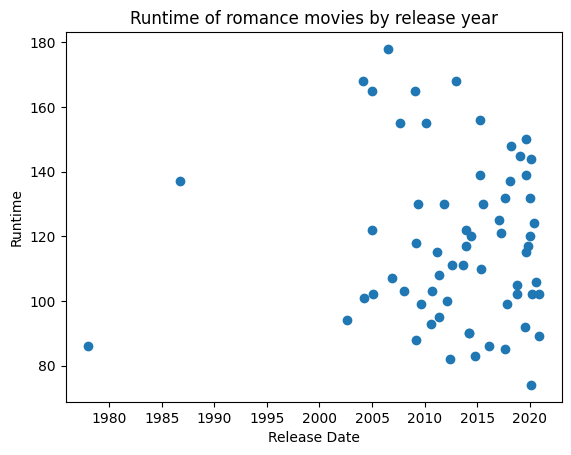

In [4]:
from matplotlib import pyplot

cursor = data320['imdb_fixed_view'].find({'genres': {'$in': ['Romance']}})
romance_films = pandas.DataFrame(cursor)

pyplot.title('Runtime of romance movies by release year')
pyplot.scatter(romance_films['release_date'], romance_films['runtime'])
pyplot.xlabel('Release Date')
pyplot.ylabel('Runtime')
pyplot.show()

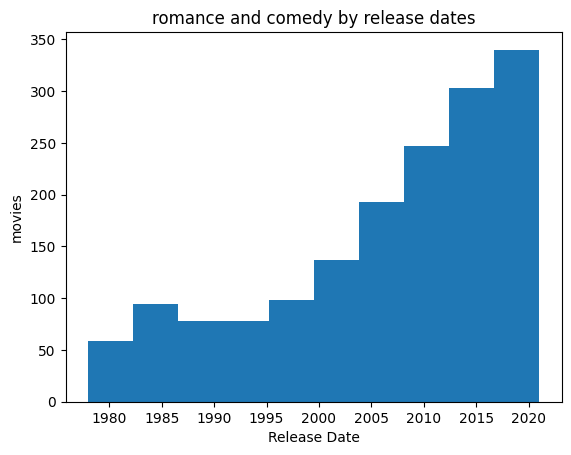

In [5]:
cursor = data320['imdb_fixed_view'].find({'genres': {'$in': ['Romance', 'Comedy']}})
romance_films = pandas.DataFrame(cursor)

pyplot.title('romance and comedy by release dates')
pyplot.hist(romance_films['release_date'])
pyplot.xlabel('Release Date')
pyplot.ylabel('movies')
pyplot.show()

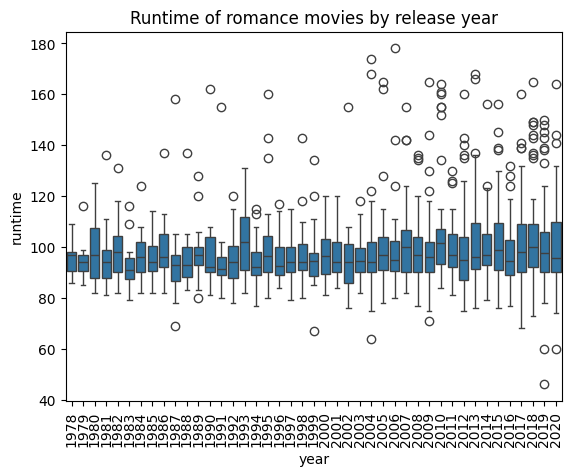

In [6]:
import seaborn

cursor = data320['imdb_fixed_view'].find({'genres': {'$in': ['Romance', 'Comedy']}})

romance_films = pandas.DataFrame(cursor)
chart = seaborn.boxplot(x = romance_films['year'], y = romance_films['runtime'])
chart.set_title('Runtime of romance movies by release year')
for item in chart.get_xticklabels():
  item.set_rotation(90)


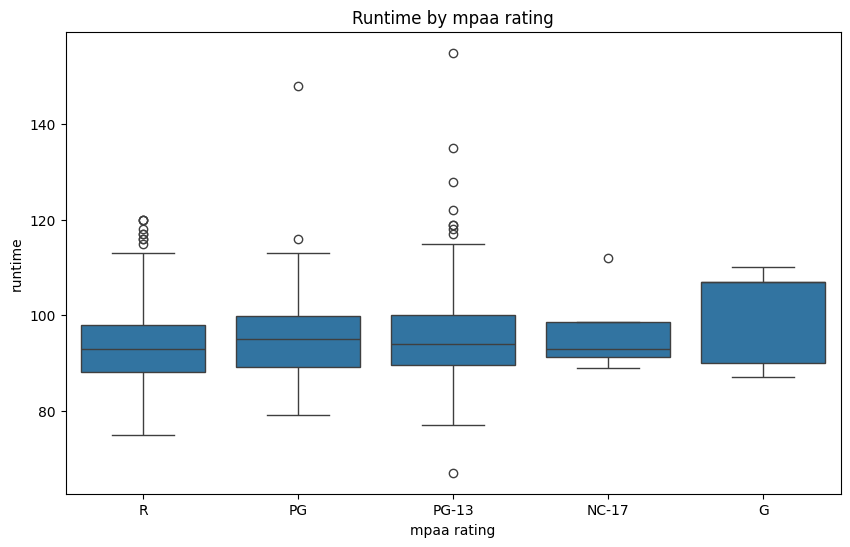

In [8]:
pyplot.figure(figsize=(10, 6))
seaborn.boxplot(x = romance_films['mpaa_rating'], y = romance_films['runtime'])
pyplot.title('Runtime by mpaa rating')
pyplot.xlabel('mpaa rating')
pyplot.ylabel('runtime')
pyplot.show()